# Lesson 2: Deploy an image classifier

Tasks:
1. Train a simple image classifier
2. Deploy the model to a web service

### Notebook setup

In [1]:
from pathlib import Path
from PIL import Image
from typing import List

In [2]:
import os
cwd = Path(os.getcwd())
if "exercises" == cwd.parts[-1]:
    print(f"Changing cwd to {cwd.parent}")
    os.chdir(cwd.parent)
else:
    print(f"cwd is {cwd}")

Changing cwd to /teamspace/studios/this_studio/fastbook


### Data curation

In [3]:
animals = 'zebra','horse'
data_dir = Path('data/animals')
data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
DOWNLOAD_DATA = False

from duckduckgo_search import DDGS
from fastai.vision.utils import download_images
from time import sleep

def search_images(term, max_images=30) -> List[str]:
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(term, max_results=max_images)
        return [x["image"] for x in ddgs_images_gen]

if DOWNLOAD_DATA:
    for nm in animals:
        dest = (data_dir/nm)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{nm} photo', max_images=20))
        sleep(10)
        download_images(dest, urls=search_images(f'{nm} sun photo', max_images=20))
        sleep(10)
        download_images(dest, urls=search_images(f'{nm} resting photo', max_images=20))
        sleep(10)
        # resize_images(dest, max_size=400, dest=dest)

ModuleNotFoundError: No module named 'duckduckgo_search'

Folder data/animals/zebra contains 60 files


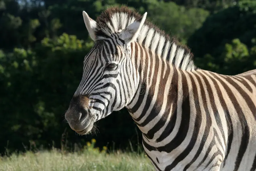

Folder data/animals/horse contains 57 files


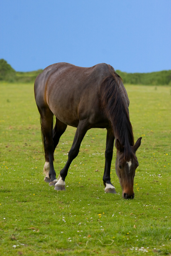

In [7]:
for a in animals:
    folder = (data_dir / a)
    files = list(folder.iterdir())
    print(f"Folder {folder} contains {len(files)} files")
    x = Image.open(files[0])
    x.thumbnail((256,256))
    display(x)

In [13]:
from fastai.vision.all import untar_data, URLs, ImageDataLoaders, get_image_files, Resize, vision_learner, resnet34, error_rate, verify_images

In [20]:
files = get_image_files(data_dir)
files

(#108) [Path('data/animals/zebra/6c66ac2c-2f56-4a1a-b10e-303cfe2adff5.jpg'),Path('data/animals/zebra/51d5bf45-d72e-45de-b44d-48b81043ded0.jpg'),Path('data/animals/zebra/e710430c-6e57-417a-9442-c9858930e8b1.jpg'),Path('data/animals/zebra/2202ddb6-e381-4a45-8fbb-71cbd1f03870.jpg'),Path('data/animals/zebra/320758c3-e55f-485d-8136-c75e07d739f3.jpg'),Path('data/animals/zebra/d452d5fc-fa7d-4606-a484-eb9fd6218a30.jpg'),Path('data/animals/zebra/c65f71c5-0d4f-4f07-8580-58bb108c09e2.jpg'),Path('data/animals/zebra/b43ff645-6164-4b3a-a620-f5a2f306cb65.jpg'),Path('data/animals/zebra/96eadfb1-85f6-486f-869f-b71e51bc07e2.jpg'),Path('data/animals/zebra/b20598d8-9597-424f-8835-b6d32facd4e5.jpg')...]

In [21]:
failed = verify_images()
failed

(#0) []

In [19]:
failed.map()

(#7) [None,None,None,None,None,None,None]

### First resnet

In [22]:
from fastai.vision.all import untar_data, URLs, ImageDataLoaders, get_image_files, Resize, vision_learner, resnet34, error_rate, verify_images, DataBlock, ImageBlock, CategoryBlock, parent_label, RandomSplitter

In [ ]:
# Download resnet and finetune 1 epoch

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(128))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

In [23]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = bears.dataloaders(data_dir)

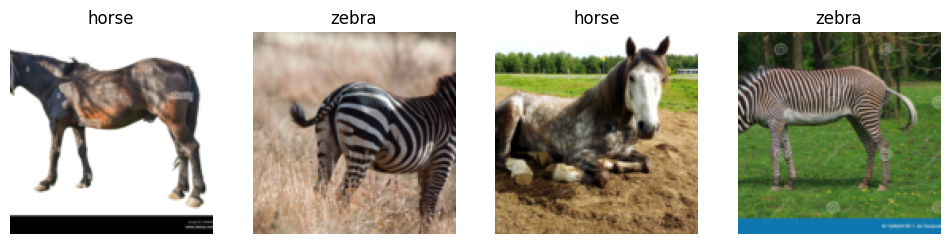

In [24]:
dls.show_batch(max_n=4, nrows=1)

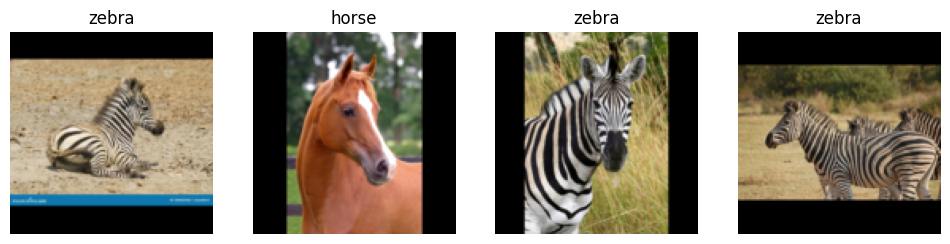

In [25]:
from fastai.vision.all import ResizeMethod

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(data_dir)
dls.valid.show_batch(max_n=4, nrows=1)

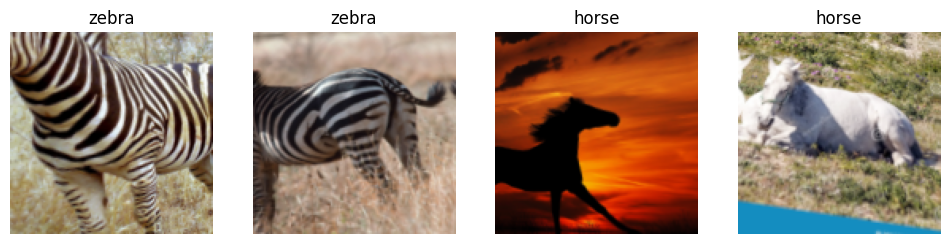

In [29]:
from fastai.vision.all import RandomResizedCrop, aug_transforms

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3), batch_tfms=aug_transforms())
dls = bears.dataloaders(data_dir)
dls.train.show_batch(max_n=4, nrows=1)

In [31]:
from fastai.vision.all import resnet18

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/zeus/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 349MB/s]


epoch     train_loss  valid_loss  error_rate  time    
0         1.093367    3.363186    0.809524    00:03                             
epoch     train_loss  valid_loss  error_rate  time    
0         1.280634    1.860611    0.666667    00:04                             
1         1.124118    0.300661    0.095238    00:04                             
2         1.019762    0.127584    0.047619    00:04                             
3         0.846993    0.092039    0.047619    00:04                             


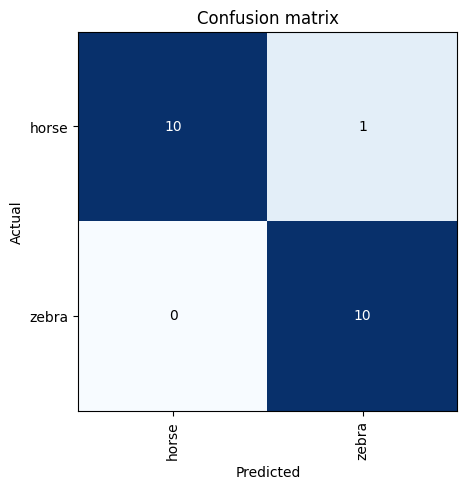

In [32]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

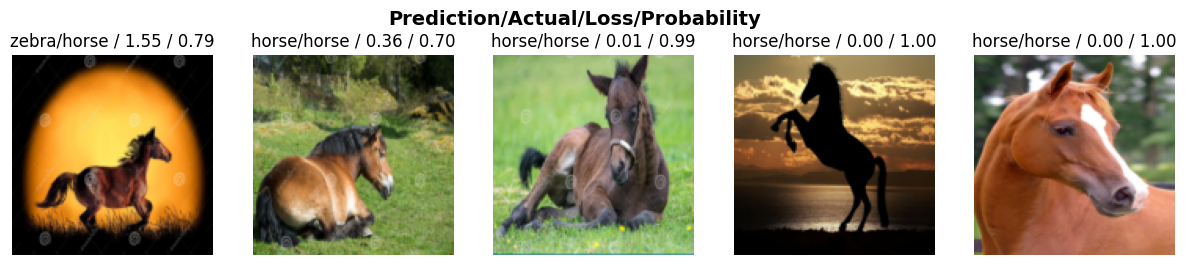

In [33]:
interp.plot_top_losses(5, nrows=1)

The Images cleaner is quite slow over ssh, so commented out. We have some horse silhouettes in there - which is a unfair because technically you can't tell if that's a horse or a zebra.

In [ ]:
# Run image cleaner - quite slow over ssh, but looks okay. Note that we have some horse 
# from fastai.vision.widgets import ImageClassifierCleaner

# cleaner = ImageClassifierCleaner(learn)
# display(cleaner)

In [45]:
save_dir = Path("results/02")
save_dir.mkdir(parents=True, exist_ok=True)
learn.export(save_dir / "export.pkl")

### Serving our classifier

Follow instructions here: https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html

In [ ]:
learn_inf = load_learner(save_dir/'export.pkl')